In [ ]:
# default_exp quantification

# Quantification

> Functions related to quantification

This notebook contains everything to perform quantification

Current ToDo here:

- Most of the functions are not very well described yet
- Introductory text to give an overview / relevant papers would be nice.

In [ ]:
#hide
from nbdev.showdoc import *

## LFQ

Algorithms related to label-free quantifications are motivated by the [MaxLFQ paper](https://doi.org/10.1074/mcp.m113.031591).


TODO: Include weighing?
TODO: Check boundaries

## In Silico Test data

To test the performance of different approaches we resort to simulating peptide intensities and adjusting them with a simulated normalization. We can then use different approaches to recover the normalization.

In [ ]:
#export
import random
import numpy as np

def gaussian(mu, sigma, grid):
    norm = 0.3989422804014327 / sigma
    return norm * np.exp(-0.5 * ((grid - mu) / sigma) ** 2)


def return_elution_profile(timepoint, sigma, n_runs):
    """
    Simulation of a Gaussian Elution Profile
    """
    return gaussian(timepoint, sigma, np.arange(0, n_runs))


def simulate_sample_profiles(n_peptides, n_runs, n_samples, threshold=0.2, use_noise=True):
    """
    Generate random profiles to serve as test data

    """
    abundances = np.random.rand(n_peptides)*10e7
    true_normalization = np.random.normal(loc=1, scale=0.1, size=(n_runs, n_samples))
    
    true_normalization[true_normalization<0] = 0
    
    true_normalization = true_normalization/np.max(true_normalization)

    maxvals = np.max(true_normalization, axis=1)

    elution_timepoints = random.choices(list(range(n_runs)), k=n_peptides)

    profiles = np.empty((n_runs, n_samples, n_peptides))
    profiles[:] = np.nan

    for i in range(n_peptides):

        elution_timepoint = elution_timepoints[i]
        abundance = abundances[i]

        profile = return_elution_profile(elution_timepoint, 1, n_runs)
        profile = profile/np.max(profile)
        profile = profile * abundance
        elution_profiles = np.tile(profile, (n_samples, 1)).T

        # Some gaussian noise
        if use_noise:
            noise = np.random.normal(1, 0.2, elution_profiles.shape)
            noisy_profile = noise * elution_profiles
        else:
            noisy_profile = elution_profiles
            
        #print(noisy_profile)

        normalized_profile = noisy_profile * true_normalization

        normalized_profile[normalized_profile < threshold] = 0
        normalized_profile[normalized_profile == 0] = np.nan
        

        profiles[:,:,i] = normalized_profile

    return profiles, true_normalization

## Delayed Normalization

In [ ]:
#export
from numba import njit, prange

@njit  
def get_peptide_error(profile, normalization): 
    
    pep_ints = np.zeros(profile.shape[1])

    normalized_profile = profile*normalization

    for i in range(len(pep_ints)):
        pep_ints[i] = np.nansum(normalized_profile[:,i])

    pep_ints = pep_ints[pep_ints>0]

    # Loop through all combinations
    n = len(pep_ints)

    error = 0
    for i in range(n):
        for j in range(i+1,n):
            error += np.abs(np.log(pep_ints[i]/pep_ints[j]))**2
            
    return error


@njit(parallel=True)
def get_total_error_parallel(normalization, profiles):
    
    normalization = normalization.reshape(profiles.shape[:2])
    
    total_error = 0
    
    for index in prange(profiles.shape[2]):
        total_error += get_peptide_error(profiles[:,:, index], normalization)
    
    return total_error


def get_total_error(normalization, profiles):
    
    normalization = normalization.reshape(profiles.shape[:2])
    
    total_error = 0
    
    for index in range(profiles.shape[2]):
        total_error += get_peptide_error(profiles[:,:, index], normalization)
    
    return total_error

## Benchmarking different optimiziers

In [ ]:
from scipy.optimize import minimize
from time import time
from scipy.optimize import least_squares
import pandas as pd


n_peptides = 100
n_runs = 10
n_samples = 3

profiles, true_normalization = simulate_sample_profiles(n_peptides, n_runs, n_samples)

methods = ['L-BFGS-B', 'TNC', 'SLSQP','trf']

results = []

for method in methods:
    
    start = time()
    
    if method in ['trf']:
        x0 = np.ones(profiles.shape[0] * profiles.shape[1])
        bounds = (x0*0.1, x0)
        res = least_squares(get_total_error, args = [profiles], bounds = bounds, x0 = x0, verbose=0, method = method)

    else:
        x0 = np.ones(profiles.shape[0] * profiles.shape[1])
        bounds = [(0.1, 1) for _ in x0]
        res = minimize(get_total_error, args = profiles , x0 = x0, bounds=bounds, method=method)

    solution = res.x/np.max(res.x)
    solution = solution.reshape(profiles.shape[:2])
    
    end = time()
    
    time_elapsed_min = (end-start)/60

    optimality = get_total_error(solution, profiles) /get_total_error(x0, profiles)
    optimality_ = get_total_error(solution, profiles) / get_total_error(true_normalization, profiles)
    
    results.append((method, time_elapsed_min, optimality, optimality_))
    
pd.DataFrame(results, columns=['Method', 'Time Elapsed (min)','Error / Baseline Error','Error / Ground Truth'])

,Method,Time Elapsed (min),Error / Baseline Error,Error / Ground Truth
0,L-BFGS-B,0.087500,0.636459,0.444292
1,TNC,0.106746,0.781960,0.545861
2,SLSQP,0.011716,0.636459,0.444292
3,trf,0.570578,0.636463,0.444294


## Implementation

In [ ]:
#export
from scipy.optimize import minimize
import pandas as pd
import numpy as np

minimum_occurence = 10

def normalize_experiment_SLSQP(profiles):
    """
    Calculate normalization with SLSQP approach
    """
    x0 = np.ones(profiles.shape[0] * profiles.shape[1])
    bounds = [(0.1, 1) for _ in x0]
    res = minimize(get_total_error, args = profiles , x0 = x0, bounds=bounds, method='SLSQP', options={'disp': False} )

    solution = res.x/np.max(res.x)
    solution = solution.reshape(profiles.shape[:2])
    
    return solution

def delayed_normalization(df, field='int_sum', minimum_occurence=None):
    """
    Returns normalization for given peptide intensities 
    """
    experiments = np.sort(df['experiment'].unique()).tolist()
    fractions = np.sort(df['fraction'].unique()).tolist()

    n_fractions = len(fractions)
    n_experiments = len(experiments)

    df_max = df.groupby(['precursor','fraction','experiment'])[field].max() #Maximum per fraction

    prec_count = df_max.index.get_level_values('precursor').value_counts()
    
    if not minimum_occurence:
        minimum_occurence = np.percentile(prec_count[prec_count>1], 75) #Take the 25% best datapoints
    
    shared_precs = prec_count[prec_count >= minimum_occurence]
    precs = prec_count[prec_count > minimum_occurence].index.tolist()

    n_profiles = len(precs)

    selected_precs = df_max.loc[precs]
    selected_precs = selected_precs.reset_index()

    profiles = np.empty((n_fractions, n_experiments, n_profiles))
    profiles[:] = np.nan

    #get dictionaries
    fraction_dict = {_:i for i,_ in enumerate(fractions)}
    experiment_dict = {_:i for i,_ in enumerate(experiments)}
    precursor_dict = {_:i for i,_ in enumerate(precs)}

    prec_id = [precursor_dict[_] for _ in selected_precs['precursor']]
    frac_id = [fraction_dict[_] for _ in selected_precs['fraction']]
    ex_id = [experiment_dict[_] for _ in selected_precs['experiment']]

    profiles[frac_id,ex_id, prec_id] = selected_precs[field]
    
    normalization = normalize_experiment_SLSQP(profiles)
    
    df[field+'_dn'] = df[field]*normalization[[fraction_dict[_] for _ in df['fraction']], [experiment_dict[_] for _ in df['experiment']]]
    
    return df, normalization

## Constructing protein intensity profiles

## Test Data

In [ ]:
import numpy as np
import string
from time import time
import pandas as pd

def generate_dummy_data(n_sequences, n_samples, noise=True, remove = True, peptide_ratio = True, abundance=True, signal_level=100, noise_divider=10, keep=0.8):

    species = ['P'+str(_) for _ in range(1,n_sequences+1)]
    sample = [string.ascii_uppercase[_] for _ in range(n_samples)]
    
    if peptide_ratio:
        peptide_ratio = np.random.rand(n_sequences)
        peptide_ratio = peptide_ratio/np.sum(peptide_ratio)
    else:
        peptide_ratio = np.ones(n_sequences)

    if abundance:
        abundance_profile = np.random.rand(n_samples,1)
    else:
        abundance_profile = np.ones((n_samples,1))

    original_signal = np.ones((n_samples, n_sequences))

    noise_sim = (np.random.rand(n_samples, n_sequences)-0.5)/noise_divider

    if noise:
        noisy_signal = original_signal+noise_sim
        noisy_signal = noisy_signal*signal_level*peptide_ratio*abundance_profile
    else:
        noisy_signal = original_signal*signal_level*peptide_ratio*abundance_profile

    if remove:
        #Remove points
        keep_probability = keep #keep 60% of the points 
        to_remove = np.random.rand(n_samples, n_sequences)
        to_remove = to_remove>=keep_probability

        dummy_data = noisy_signal.copy()

        dummy_data[to_remove] = 0

    else:
        dummy_data = noisy_signal

            
    dummy_data = pd.DataFrame(dummy_data, index = sample, columns = species).T
    
    ground_truth = abundance_profile.flatten()
    ground_truth = ground_truth/np.max(ground_truth)
        
    return dummy_data, sample, ground_truth

## Determine pair-wise intenisty ratios



In [ ]:
from numba import njit

@njit
def get_protein_ratios(signal, column_combinations, minimum_ratios = 2):
    n_samples = signal.shape[1]
    ratios = np.empty((n_samples, n_samples))
    ratios[:] = np.nan

    for element in column_combinations:
        i = element[0]
        j = element[1]

        ratio = signal[:,j] / signal[:,i]
        
        non_nan = np.sum(~np.isnan(ratio))

        if non_nan >= minimum_ratios:
            ratio_median = np.nanmedian(ratio)
        else:
            ratio_median = np.nan

        ratios[j,i] = ratio_median
    
    return ratios 

## Error Function

In [ ]:
@njit
def triangle_error(normalization, ratios):
    int_matrix = np.repeat(normalization, len(normalization)).reshape((len(normalization), len(normalization))).transpose()
    x = (np.log(ratios) - np.log(int_matrix.T) + np.log(int_matrix))**2
    
    return np.nansum(x)

## Different ways to solve

In [ ]:
## L-BFGS-B

from scipy.optimize import minimize

# LFBGSB

def solve_profile_LFBGSB(ratios):
    x0 = np.ones(ratios.shape[1])
    bounds = [(x0[0]*0+0.01, x0[0]-0.01) for _ in x0]
    res_wrapped = minimize(triangle_error, args = ratios , x0 = x0, bounds=bounds, method = 'L-BFGS-B')
    solution = res_wrapped.x
    solution = solution/np.max(solution)
    return solution, res_wrapped.success


def solve_profile_SLSQP(ratios):
    x0 = np.ones(ratios.shape[1])
    bounds = [(x0[0]*0+0.01, x0[0]-0.01) for _ in x0]
    res_wrapped = minimize(triangle_error, args = ratios , x0 = x0, bounds=bounds, method = 'SLSQP', options={'maxiter':10000})
    solution = res_wrapped.x
    solution = solution/np.max(solution)
    return solution, res_wrapped.success


# TRF
def solve_profile_trf(ratios):
    x0 = np.ones(ratios.shape[1])
    bounds = (x0*0+0.01, x0-0.01)
    res_wrapped = least_squares(triangle_error, args = [ratios] , x0 = x0, bounds=bounds, verbose=0, method = 'trf')
    solution = res_wrapped.x
    solution = solution/np.max(solution)
    return solution, res_wrapped.success


## Benchmarking different Optimizers

In [ ]:

from itertools import combinations
from numba.typed import List

n_samples = signal.shape[1]

column_combinations = List()
[column_combinations.append(_) for _ in combinations(range(n_samples), 2)]


methods = {'L-FBGS-B':solve_profile_LFBGSB, 'SLSQP':solve_profile_SLSQP, 'trf':solve_profile_trf}
results = []

for run in range(20):
    signal, sample, ground_truth = generate_dummy_data(10,6)
    ratios = get_protein_ratios(signal.values, column_combinations)

    for method in methods.keys():
        error = False
        start = time()
        try:
            solution, success = methods[method](ratios)
            mape = np.mean(np.abs((solution-ground_truth)/ground_truth))
        except:
            error = True
            mape = np.nan
            
        
        end = time()

        time_elapsed_s = (end-start)

        results.append((method, time_elapsed_s, mape, error, success))
    
result_df = pd.DataFrame(results, columns=['Method', 'Time Elapsed (s)', 'Mean absolute percentage error', 'Errors', 'Success'])

result_df.groupby('Method').mean()

C:\ProgramData\Anaconda3\envs\alphap\lib\site-packages\scipy\optimize\slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon


,Time Elapsed (s),Mean absolute percentage error,Errors,Success
Method,,,,
L-FBGS-B,0.002457,0.084485,0.0,0.95
SLSQP,0.005117,0.024116,0.0,1.00
trf,0.000000,NaN,1.0,1.00


> SLSQP seems to be a robust and fast choice

## Wrapper function

In [ ]:
from numba.typed import List
from itertools import combinations

def get_protein_table(df, field = 'int_sum', callback = None):
    unique_proteins = df['protein'].unique()
    experiments = df['experiment'].unique().tolist()
    experiments.sort()
    
    column_combinations = List()
    [column_combinations.append(_) for _ in combinations(range(len(experiments)), 2)]
        
    columnes_ext = [_+'_LFQ' for _ in experiments]
    protein_table = pd.DataFrame(index=unique_proteins, columns=columnes_ext + experiments)

    if field+'_dn' in df.columns:
        field_ = field+'_dn'
    else:
        field_ = field

    for idx, protein in enumerate(unique_proteins):
        subset = df[df['protein'] == protein].copy()
        per_protein = subset.groupby(['experiment','precursor'])[field_].sum().unstack().T
        ratios = get_protein_ratios(per_protein.values, column_combinations)
        experiment_ids = per_protein.columns.tolist()
        solution, success= solve_profile_SLSQP(ratios)

        pre_lfq = per_protein.sum().values

        if not success or np.sum(~np.isnan(ratios)) == 0: # or np.sum(solution) == len(pre_lfq):
            profile = pre_lfq
        else:
            total_int = subset[field_].sum()
            total_int_ = np.sum(solution)
            profile = total_int/total_int_*solution

        protein_table.loc[protein, [_+'_LFQ' for _ in experiment_ids]] = profile
        protein_table.loc[protein, experiment_ids] = pre_lfq
        
        if callback:
            callback((idx+1)/len(unique_proteins))
        
    protein_table = protein_table.astype('float')

    return protein_table

In [ ]:
df = pd.read_hdf('../protein_export.hdf5')

In [ ]:
protein_table = get_protein_table(df)

In [ ]:
protein_table

,H1_LFQ,H2_LFQ,H3_LFQ,L1_LFQ,L2_LFQ,L3_LFQ,H1,H2,H3,L1,L2,L3
sp|P04075|ALDOA_HUMAN,2.916626e+08,2.909984e+08,4.516589e+08,1.111302e+09,7.662443e+08,9.440061e+08,3.212569e+08,6.161433e+08,3.677183e+08,1.278509e+09,5.362939e+08,7.359515e+08
sp|P31948|STIP1_HUMAN,1.714980e+08,2.714961e+08,1.958472e+08,3.665722e+08,3.405037e+08,1.879640e+08,1.185026e+08,1.729139e+08,1.479079e+08,4.875966e+08,4.491561e+08,1.578040e+08
sp|P26639|SYTC_HUMAN,6.743886e+07,7.891265e+07,3.387771e+07,1.462028e+08,1.103586e+08,1.140973e+08,5.772160e+07,1.342937e+08,6.157710e+07,1.019365e+08,9.696970e+07,9.838927e+07
sp|O43684|BUB3_HUMAN,1.993779e+07,8.310716e+07,5.170905e+07,7.254796e+07,5.877639e+07,1.330190e+08,2.540570e+07,6.671159e+07,4.339218e+07,8.325319e+07,4.989373e+07,1.504410e+08
sp|P06748|NPM_HUMAN,1.409211e+09,1.782132e+09,1.683457e+09,2.532160e+09,2.361906e+09,3.189431e+09,1.289095e+09,2.642319e+09,1.648315e+09,3.162360e+09,1.543506e+09,2.672701e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
sp|P77374|YNFE_ECOLI,NaN,1.470491e+05,NaN,NaN,NaN,NaN,NaN,1.470491e+05,NaN,NaN,NaN,NaN
sp|P37767|YFHH_ECOLI,2.296468e+05,2.554903e+05,NaN,NaN,NaN,NaN,2.296468e+05,2.554903e+05,NaN,NaN,NaN,NaN
sp|B7L542|YAII_ECO55,1.574675e+06,NaN,NaN,NaN,NaN,NaN,1.574675e+06,NaN,NaN,NaN,NaN,NaN
sp|Q8N983|RM43_HUMAN,2.907433e+05,NaN,NaN,NaN,NaN,NaN,2.907433e+05,NaN,NaN,NaN,NaN,NaN


In [ ]:
protein_table = protein_table.apply(np.log10)

protein_table['human'] = protein_table.index.str.contains('HUMAN')
protein_table['eco'] = protein_table.index.str.contains('ECO')

protein_table['H_LFQ'] = protein_table[['H1_LFQ','H2_LFQ','H3_LFQ']].mean(axis=1)
protein_table['L_LFQ'] = protein_table[['L1_LFQ','L2_LFQ','L3_LFQ']].mean(axis=1)

protein_table['LFQ_ratio'] = protein_table['H_LFQ'] / protein_table['L_LFQ']
protein_table['LFQ_sum'] = protein_table['H_LFQ'] + protein_table['L_LFQ']

protein_table['H'] = protein_table[['H1','H2','H3']].mean(axis=1)
protein_table['L'] = protein_table[['L1','L2','L3']].mean(axis=1)

protein_table['_ratio'] = protein_table['H'] / protein_table['L']
protein_table['_sum'] = protein_table['H'] + protein_table['L']


protein_table['H_count'] = protein_table[['H1_LFQ','H2_LFQ','H3_LFQ']].count(axis=1)
protein_table['L_count'] = protein_table[['L1_LFQ','L2_LFQ','L3_LFQ']].count(axis=1)

In [ ]:
sub = protein_table.query('H_count >= 2 and L_count >=2')

<ipython-input-480-ffedb50b7f2e>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eco = sub[protein_table['eco']]


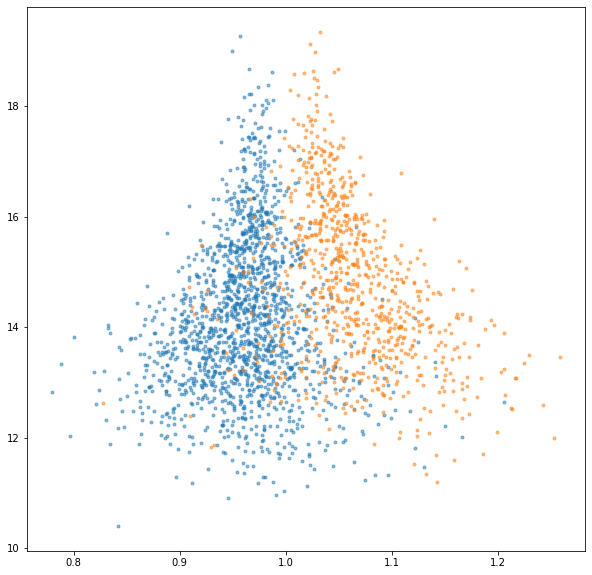

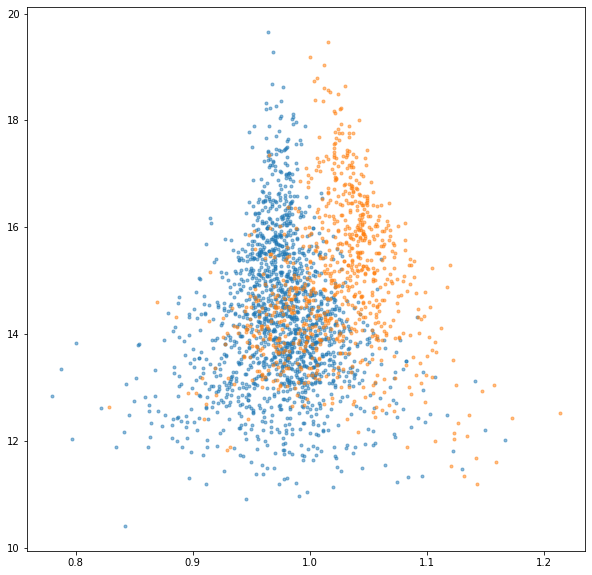

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))

human = sub[sub['human']]
eco = sub[protein_table['eco']]
plt.plot(human['_ratio'], human['_sum'],'.', alpha=0.5)
plt.plot(eco['_ratio'], eco['_sum'],'.', alpha=0.5)


plt.figure(figsize=(10,10))

plt.plot(human['LFQ_ratio'], human['LFQ_sum'],'.', alpha=0.5)
plt.plot(eco['LFQ_ratio'], eco['LFQ_sum'],'.', alpha=0.5)

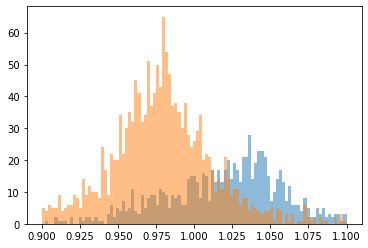

In [ ]:
bins = np.linspace(0.9,1.1,100)

plt.hist(eco['LFQ_ratio'],bins=bins, alpha=0.5)
plt.hist(human['LFQ_ratio'],bins=bins, alpha=0.5)
plt.show()

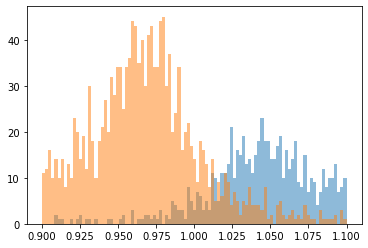

In [ ]:
bins = np.linspace(0.9,1.1,100)

plt.hist(eco['_ratio'],bins=bins, alpha=0.5)
plt.hist(human['_ratio'],bins=bins, alpha=0.5)
plt.show()

In [ ]:
protein_table[protein_table['LFQ_ratio'] == 1.0]

,H1_LFQ,H2_LFQ,H3_LFQ,L1_LFQ,L2_LFQ,L3_LFQ,H1,H2,H3,L1,...,H_LFQ,L_LFQ,LFQ_ratio,LFQ_sum,H,L,_ratio,_sum,H_count,L_count


In [ ]:
subset = df[df['protein'] == 'sp|Q9BTE6|AASD1_HUMAN'].copy()
per_protein = subset.groupby(['experiment','precursor'])[field_].sum().unstack().T
ratios = get_protein_ratios(per_protein.values, column_combinations)
experiment_ids = per_protein.columns.tolist()
solution, success= solve_profile_SLSQP(ratios)

In [ ]:
per_protein

experiment,H1,H2,L1,L2,L3
precursor,,,,,
GGGLFLLAGPPASVETLGPR_2,NaN,1.057695e+06,958407.980261,2.565359e+06,1.305568e+06
TNLIFLSGNR_2,248488.36212,NaN,NaN,NaN,NaN


In [ ]:
subset = df[df['protein'] == 'sp|Q9UBM7|DHCR7_HUMAN'].copy()
per_protein = subset.groupby(['experiment','precursor'])[field_].sum().unstack().T
ratios = get_protein_ratios(per_protein.values, column_combinations)
experiment_ids = per_protein.columns.tolist()
solution, success= solve_profile_SLSQP(ratios)

In [ ]:
per_protein

experiment,H1,H2,L1,L2,L3
precursor,,,,,
FLPGYVGGIQEGAVTPAGVVNK_2,2.784715e+06,NaN,7.328927e+06,6.589543e+06,1.477845e+06
LLVSGFWGVAR_2,NaN,375629.779993,NaN,NaN,NaN


In [ ]:
np.sum(~np.isnan(ratios))

0

In [ ]:
solution

array([1., 1., 1., 1., 1.])

In [ ]:
df[df['protein'] == 'sp|Q13835|PKP1_HUMAN']['int_sum']

188932    1033425
Name: int_sum, dtype: int64

In [ ]:
per_protein.unstack()

experiment  precursor         
H1          AAPQPLNLVSSVTLSK_2    3447931
dtype: int64

In [ ]:
total_int_

3.053215672524739

In [ ]:
solve_profile_SLSQP(ratios)

array([0.2945468 , 0.27662017, 1.        , 0.43717327, 0.57789989,
       0.46697555])

In [ ]:
subset['int_sum'].sum()

14038144238

In [ ]:
#hide
from nbdev.export import *
notebook2script()